# Antibody binding to RBD point mutants in mammalian display system
Plot Allie Greaney and Andrea Loes's flow cytometry data on antibody binding to mammalian-cell displayed RBD mutants.
These are displayed using the RBD-B7.1TM plasmid system.
These data are useful for antibodies like CR3022 that aren't neutralizing and so can't be validated in neutralization assays.

Import Python modules:

In [1]:
import os

import neutcurve
from neutcurve.colorschemes import CBPALETTE

import numpy

import pandas as pd
from pandas.api.types import CategoricalDtype

from plotnine import *

/fh/fast/bloom_j/computational_notebooks/jbloom/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/dmslogo/logo.py:40: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  matplotlib.font_manager.findSystemFonts(_FONT_PATH)))


Make output directory for results from running notebook:

In [2]:
os.makedirs('results', exist_ok=True)

Read in the data for the experiments from the CSV files that Allie generated:

* **2020-07-17:** CR3022 binding to WT RBD and 2 mutants

* **2020-07-29:** CR3022 and COV2-2082 binding to WT RBD and some number of mutants. 

Allie quantified the antibody binding signal by computing a "mean bin" score of four flow cytometry bins that could range from 1 to 4.
Note that in order to enable better curve fitting with [neutcurve](https://jbloomlab.github.io/neutcurve/), we change the mean bin to start at 0 and go to 3.
(This works better because [neutcurve](https://jbloomlab.github.io/neutcurve/) is designed to fit data with lower limits of zero and works most efficiently in that case.)

In [3]:
dates = ['200729', '200717']

all_data = (
    pd.concat([pd.read_csv(f"{date}_Table.csv").assign(date=date)
               for date in dates])
    .drop(columns=['WELL ID', 'Cells', 'Single Cells', 'Single Cells2',
                   'SingleCells3', 'ACE2pos', 'Unnamed: 0'])
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%y%m%d'),
            antibody_date=lambda x: x['antibody'] + ' (' + x['date'].astype(str) + ')',
            mean_bin=lambda x: x['mean_bin'] - 1,  # make mean bin start at 0
            logMFI_antibody=lambda x: numpy.log(x['APC_geomean']),
            logMFI_expression=lambda x: numpy.log(x['PE_geomean']),
            )
    .sort_values(['antibody', 'date'])
    .reset_index(drop=True)
    )  

all_data.head()

,genotype,antibody,replicate,concentration,units,APC_geomean,PE_geomean,bin1,bin2,bin3,bin4,mean_bin,date,antibody_date,logMFI_antibody,logMFI_expression
0,wildtype,COV2-2082,1,0.00000,ng_per_mL,19.5,3543,89.60,10.4,0.00,0.000,0.104000,2020-07-29,COV2-2082 (2020-07-29),2.970414,8.172729
1,wildtype,COV2-2082,1,0.00512,ng_per_mL,55.6,3525,60.60,39.1,0.28,0.000,0.396679,2020-07-29,COV2-2082 (2020-07-29),4.018183,8.167636
2,wildtype,COV2-2082,1,0.02560,ng_per_mL,92.1,3404,46.90,50.4,2.75,0.000,0.558721,2020-07-29,COV2-2082 (2020-07-29),4.522875,8.132706
3,wildtype,COV2-2082,1,0.12800,ng_per_mL,293.0,3500,21.00,63.5,15.50,0.012,0.945247,2020-07-29,COV2-2082 (2020-07-29),5.680173,8.160518
4,wildtype,COV2-2082,1,0.64000,ng_per_mL,746.0,3447,5.59,63.1,31.30,0.023,1.257527,2020-07-29,COV2-2082 (2020-07-29),6.614726,8.145260


The curve-fitting works best when the Y-axis lower limit is zero.
I will subtract the minimum CR3022 logMFI (because from running the notebook previous times, I know the curve will not fit to 2082 anyway, and we will probably only want the CR3022 data for the paper) from everything. 

Indeed, this makes the curve fitting work a lot better for CR3022 x K378N. 

And get just the data relevant for the RBD-antibody binding curves:

In [4]:
min_MFI = (all_data
            .query('antibody == "CR3022"')
            .query('concentration > 0')
            ['logMFI_antibody']
            ).min()

print(min_MFI)

3.126760535960395


In [5]:
rbd_data = (all_data
            .query('genotype != "untransfected"')
            .query('concentration > 0')
            .assign(logMFI_antibody_normalized=lambda x: x['logMFI_antibody'] - min_MFI)
            )

Use [neutcurve](https://jbloomlab.github.io/neutcurve/) to fit and plot curves to all measurements.
If there are replicates, it automatically fits the mean.

Note that `neutcurve` will not fit a curve for *COV2-2082* for wildtype.
In her original analysis, Allie just excluded the second and third points for this curve.
This allows `neutcurve` to fit a curve to the COV2-2082 wildtype. 
Make a plot excluding those:

/fh/fast/bloom_j/computational_notebooks/jbloom/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/neutcurve/hillcurve.py:691: RuntimeWarning: invalid value encountered in power
  return t + (b - t) / (1 + (c / m)**s)


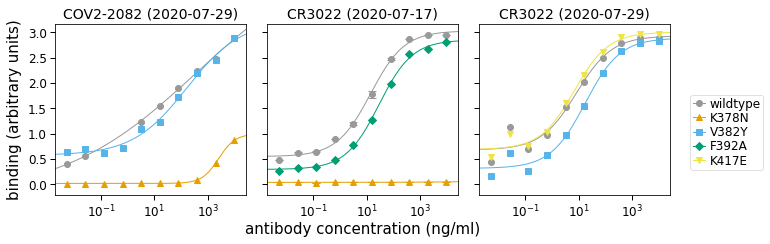

In [6]:
fits_exclude = neutcurve.CurveFits(
                           rbd_data.query('not (antibody == "COV2-2082" and '
                                          '     genotype == "wildtype" and '
                                          '     concentration in [0.128, 0.64])'),
                           fracinf_col='mean_bin',
                           serum_col='antibody_date',
                           virus_col='genotype',
                           fixbottom=False,
                           fixtop=False,
                           infectivity_or_neutralized='neutralized',
                           )

_ = fits_exclude.plotSera(
              xlabel='antibody concentration (ng/ml)',
              ylabel='binding (arbitrary units)',
              heightscale=1.2,
              )

The above plots excluding those points looks a little bit better.
However, I'm not sure if we have a good rationale for arbitrarily just excluding these two points?
And in any case, a curve that excludes them is missing data in a key region.

In any case, it doesn't seem like we really care about *COV2-2082* as we can measure **neutralization** for it.
CR3022 is the only antibody that is non-neutralizing and for which we need to use RBD display rather than neutralization.
So fit just the CR3022 data.
The below plot might make a nice supplementary figure, so save it:

/fh/fast/bloom_j/computational_notebooks/jbloom/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/neutcurve/hillcurve.py:691: RuntimeWarning: invalid value encountered in power
  return t + (b - t) / (1 + (c / m)**s)


Saving curve to results/EC50_curves.pdf


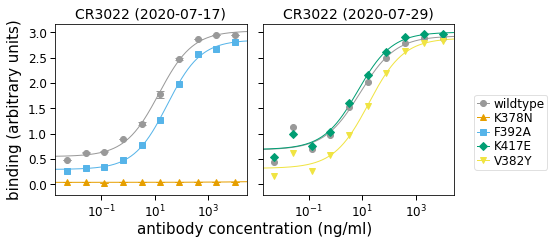

In [7]:
fits = neutcurve.CurveFits(
                           rbd_data.query('antibody != "COV2-2082"'),
                           fracinf_col='mean_bin',
                           serum_col='antibody_date',
                           virus_col='genotype',
                           fixbottom=False,
                           fixtop=False,
                           infectivity_or_neutralized='neutralized',
                           )

fig, ax = fits.plotSera(
              xlabel='antibody concentration (ng/ml)',
              ylabel='binding (arbitrary units)',
              heightscale=1.2,
              )

plotfile = 'results/EC50_curves.pdf'
print(f"Saving curve to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

Plot fits for logMFI for CR3022.
Note that I tried this for COV2-2082, and the curves would not fit, possibly because the shape with MFI would not be fit well by a Hill curve. 

/fh/fast/bloom_j/computational_notebooks/jbloom/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/neutcurve/hillcurve.py:691: RuntimeWarning: invalid value encountered in power
  return t + (b - t) / (1 + (c / m)**s)


Saving curve to results/EC50_curves_MFI.pdf


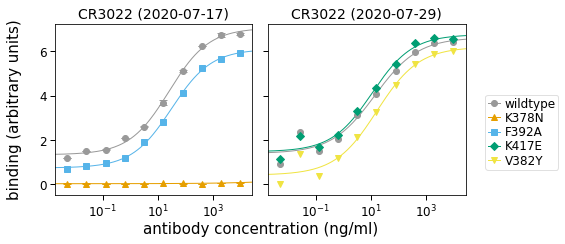

In [8]:
fits_logMFI = neutcurve.CurveFits(
                        rbd_data.query("antibody=='CR3022'"),
                        fracinf_col='logMFI_antibody_normalized',
                        serum_col='antibody_date',
                        virus_col='genotype',
                        fixbottom=False,
                        fixtop=False,
                        infectivity_or_neutralized='neutralized',
                        )

_ = fits_logMFI.plotSera(
            xlabel='antibody concentration (ng/ml)',
            ylabel='binding (arbitrary units)',
            heightscale=1.2,
            )

plotfile = 'results/EC50_curves_MFI.pdf'
print(f"Saving curve to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

Now get the fit parameters for each curve.
[neutcurve](https://jbloomlab.github.io/neutcurve/) is set up to report IC50s, but it specifically reports those as the value where we have 50% of a signal between 0 and 1.
In this case, every curve has different baselines and generally don't go from 0 to 1, so we want the **midpoints** rather than the IC50s.
So extract the IC50s, and also determine if the midpoint is an upper / lower bound given the concentration ranges used, or if it is an interpolated value:

In [9]:
fitparams = (
    fits.fitParams()
    .rename(columns={'serum': 'antibody_date'})
    # add back antibody name and max concentration for each
    .merge(rbd_data.groupby(['antibody_date', 'antibody', 'date'])
                   .aggregate(max_concentration=pd.NamedAgg('concentration', 'max'),
                              min_concentration=pd.NamedAgg('concentration', 'min'))
                   .reset_index(),
           on='antibody_date',
           how='left',
           validate='many_to_one',
           )
    # is the midpoint an upper or lower bound
    .assign(midpoint_is_bound=lambda x: (x['min_concentration'] > x['midpoint']) |
                                        (x['max_concentration'] < x['midpoint']),
            midpoint=lambda x: numpy.clip(x['midpoint'], x['min_concentration'], x['max_concentration'])
            )
    # get columns of interest
    [['antibody', 'date', 'virus', 'midpoint', 'midpoint_is_bound']]
    )

fitparams

,antibody,date,virus,midpoint,midpoint_is_bound
0,CR3022,2020-07-17,wildtype,14.205197,False
1,CR3022,2020-07-17,K378N,10000.000000,True
2,CR3022,2020-07-17,F392A,29.320781,False
3,CR3022,2020-07-29,wildtype,8.253859,False
4,CR3022,2020-07-29,K417E,6.797398,False
5,CR3022,2020-07-29,V382Y,17.477845,False


In [10]:
fitparams_MFI = (
    fits_logMFI.fitParams()
    .rename(columns={'serum': 'antibody_date'})
    # add back antibody name and max concentration for each
    .merge(rbd_data.groupby(['antibody_date', 'antibody', 'date'])
                   .aggregate(max_concentration=pd.NamedAgg('concentration', 'max'),
                              min_concentration=pd.NamedAgg('concentration', 'min'))
                   .reset_index(),
           on='antibody_date',
           how='left',
           validate='many_to_one',
           )
    # is the midpoint an upper or lower bound
    .assign(midpoint_is_bound=lambda x: (x['min_concentration'] > x['midpoint']) |
                                        (x['max_concentration'] < x['midpoint']),
            midpoint=lambda x: numpy.clip(x['midpoint'], x['min_concentration'], x['max_concentration'])
            )
    # get columns of interest
    [['antibody', 'date', 'virus', 'midpoint', 'midpoint_is_bound']]
    )

fitparams_MFI

,antibody,date,virus,midpoint,midpoint_is_bound
0,CR3022,2020-07-17,wildtype,25.702789,False
1,CR3022,2020-07-17,K378N,10000.000000,True
2,CR3022,2020-07-17,F392A,31.698999,False
3,CR3022,2020-07-29,wildtype,13.943110,False
4,CR3022,2020-07-29,K417E,11.025398,False
5,CR3022,2020-07-29,V382Y,16.556823,False


Now compute the fold change in midpoint relative to the wildtype run on the same day:

In [11]:
foldchange = (
    fitparams
    .query('virus != "wildtype"')
    .rename(columns={'virus': 'mutant'})
    .merge(fitparams.query('virus == "wildtype"')
                    [['antibody', 'date', 'midpoint']]
                    .rename(columns={'midpoint': 'wildtype_midpoint'}),
           on=['antibody', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['midpoint'] / x['wildtype_midpoint'],
            log2_fold_change=lambda x: numpy.log(x['fold_change']) / numpy.log(2))
    )

foldchange

,antibody,date,mutant,midpoint,midpoint_is_bound,wildtype_midpoint,fold_change,log2_fold_change
0,CR3022,2020-07-17,K378N,10000.000000,True,14.205197,703.967727,9.459365
1,CR3022,2020-07-17,F392A,29.320781,False,14.205197,2.064088,1.045505
2,CR3022,2020-07-29,K417E,6.797398,False,8.253859,0.823542,-0.280086
3,CR3022,2020-07-29,V382Y,17.477845,False,8.253859,2.117536,1.082387


In [12]:
foldchange_MFI = (
    fitparams_MFI
    .query('virus != "wildtype"')
    .rename(columns={'virus': 'mutant'})
    .merge(fitparams_MFI.query('virus == "wildtype"')
                    [['antibody', 'date', 'midpoint']]
                    .rename(columns={'midpoint': 'wildtype_midpoint'}),
           on=['antibody', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['midpoint'] / x['wildtype_midpoint'],
            log2_fold_change=lambda x: numpy.log(x['fold_change']) / numpy.log(2))
    )

foldchange_MFI

,antibody,date,mutant,midpoint,midpoint_is_bound,wildtype_midpoint,fold_change,log2_fold_change
0,CR3022,2020-07-17,K378N,10000.000000,True,25.702789,389.062841,8.603859
1,CR3022,2020-07-17,F392A,31.698999,False,25.702789,1.233290,0.302512
2,CR3022,2020-07-29,K417E,11.025398,False,13.943110,0.790742,-0.338722
3,CR3022,2020-07-29,V382Y,16.556823,False,13.943110,1.187456,0.247873


Now plot these midpoints fold changes, calling them "EC50s" since they are if we account for fact signal doesn't go from 0 to 1.
In order not to have the y-axis blown out, we put an upper bound on the largest value and plot points at this bound in a different color.

This could be a main plot, so save it to a file:

Saving to results/fold_change_EC50.pdf


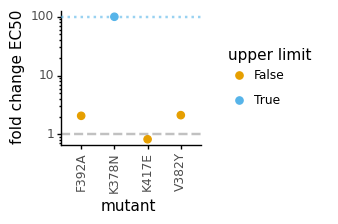

In [13]:
fold_change_upper_bound = 100  # plot fold-change in EC50 >= this as this

# upper bound for plotting
upper_bound = fold_change_upper_bound
if foldchange['midpoint_is_bound'].any():
    upper_bound = min(upper_bound, foldchange
                                   .query('midpoint_is_bound')
                                   ['fold_change']
                                   .min())

p = (ggplot(foldchange
            .assign(fold_change=lambda x: numpy.clip(x['fold_change'],
                                                     None, fold_change_upper_bound),
                    midpoint_is_bound=lambda x: x['midpoint_is_bound'] |
                                                (x['fold_change'] == fold_change_upper_bound),
                    )
            ) +
     aes('mutant', 'fold_change', color='midpoint_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change EC50') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.45 * foldchange['mutant'].nunique(), 1.75),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(yintercept=upper_bound, linetype='dotted', size=1,
                alpha=0.6, color=CBPALETTE[2]) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = 'results/fold_change_EC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Write to a file the foldchange and upper bound data frames:

In [14]:
(foldchange
 .assign(fold_change=lambda x: numpy.clip(x['fold_change'],
                                          None, fold_change_upper_bound)
         )
 .to_csv('results/foldchange.csv', index=False)
 )

(pd.DataFrame({'antibody': ['CR3022'], 'fold_change': [fold_change_upper_bound]})
 .to_csv('results/upper_bound.csv')
 )

Make the same plots using MFI instead:

Saving to results/fold_change_EC50_MFI.pdf


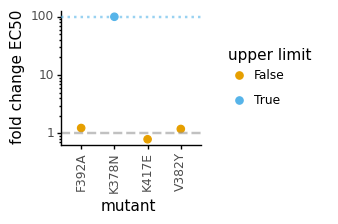

In [15]:
fold_change_upper_bound = 100  # plot fold-change in EC50 >= this as this

# upper bound for plotting
upper_bound = fold_change_upper_bound
if foldchange_MFI['midpoint_is_bound'].any():
    upper_bound = min(upper_bound, foldchange
                                   .query('midpoint_is_bound')
                                   ['fold_change']
                                   .min())

p = (ggplot(foldchange_MFI
            .assign(fold_change=lambda x: numpy.clip(x['fold_change'],
                                                     None, fold_change_upper_bound),
                    midpoint_is_bound=lambda x: x['midpoint_is_bound'] |
                                                (x['fold_change'] == fold_change_upper_bound),
                    )
            ) +
     aes('mutant', 'fold_change', color='midpoint_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change EC50') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.45 * foldchange_MFI['mutant'].nunique(), 1.75),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(yintercept=upper_bound, linetype='dotted', size=1,
                alpha=0.6, color=CBPALETTE[2]) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = 'results/fold_change_EC50_MFI.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

It looks like the fold change in EC50 is greater for the mutants with subtle effect when the data are displayed as `mean_bin` rather than `logMFI`. 
This makes sense, given that the data look a somewhat cleaner as `mean_bin`.
I think we will probably want to carry the `mean_bin` analysis forward for the paper. 

Finally, we want to plot the flow cytometry reading for RBD **expression**, which is measured by a different fluorescent tag, just to prove all RBDs expressed.
There are lots of expression measurements (one at each antibody concentration), so just plot distribution of all of them.
This could be another supplementary plot, so save it:

Saving to results/RBD_expression.pdf


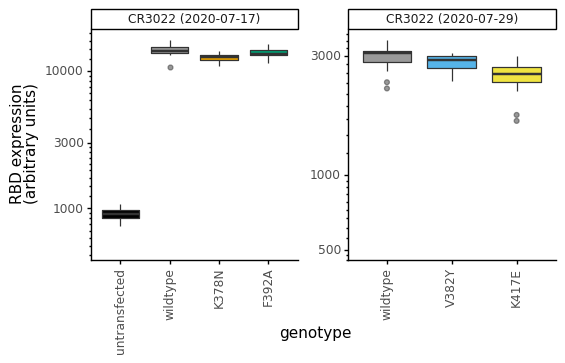

In [16]:
cat_type = CategoricalDtype(categories=["untransfected", "wildtype", "K378N", "V382Y", "F392A", "K417E",],
                            ordered=True)

all_data['genotype']=all_data['genotype'].astype(cat_type)

p = (ggplot(all_data.query('antibody != "COV2-2082"')) +
     aes('genotype', 'PE_geomean', fill='genotype') +
     geom_boxplot(outlier_alpha=0.5) +
     facet_wrap('~ antibody_date',
                scales='free',
                ) +
     ylab('RBD expression\n(arbitrary units)') +
     scale_y_log10()+
     expand_limits(y=5e2) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           panel_spacing=0.5,
           figure_size=(6, 3),
           ) +
     scale_fill_manual(values=['black']+list(CBPALETTE), guide=False)
     )

_ = p.draw()

plotfile = 'results/RBD_expression.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)